In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
from matplotlib import pyplot as plt
import requests, json
import numpy as np
# from scipy.signal import medfilt2d
import sys
import os
sys.path.append('/Users/bpb/repos/openmsi-programmatic-access/')
import openmsi


In [56]:
client = requests.Session()
client = openmsi.authenticateUser(client,'username')

In [55]:
# files = openmsi.getFilelist(client)
# for f in files:
#     print f

In [4]:
myFile = '/project/projectdirs/openmsi/omsi_data_private/raad0102/20180202MdR_5800_FOTS_on_chip_peptide_separation_2.h5'

(134, 102, 106742)


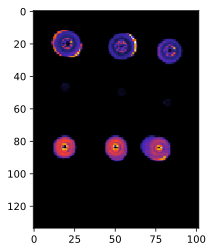

In [5]:
# myIons = [1241.25, 917.5, 817.6]
myIons = [634.4,748.45]
myRange = 2 # integrate at +/- this amount
# filename = '/project/projectdirs/openmsi/omsi_data_private/bpb/20120913_nimzyme.h5'
import ast
dataIndex = '0'
expIndex = '0'
payload = {'file':myFile,'format':'JSON','mtype':'file','expIndex':expIndex,'dataIndex':dataIndex}
url = 'https://openmsi.nersc.gov/openmsi/qmetadata'
r = client.get(url,params=payload)
metadata = json.loads(r.content)
originalSize = ast.literal_eval(metadata[u'children'][0][u'shape'])
print originalSize


mz = openmsi.getMZ(client,myFile,expIndex,dataIndex)
imStack = np.zeros((originalSize[0],originalSize[1],len(myIons)))
for i,ion in enumerate(myIons):
    idx = np.where(abs(mz-ion)<myRange)
    payload = {'file':myFile,
               'expIndex':expIndex,'dataIndex':dataIndex,'format':'JSON','mz':'%d:%d'%(min(idx[0]),max(idx[0]))}
    url = 'https://openmsi.nersc.gov/openmsi/qcube'
    r = client.get(url,params=payload)
    data = np.asarray(json.loads(r.content))
#     imStack[:,:,i] = np.sum(data,2)
    imStack[:,:,i] = np.max(data,2)

baseImage = np.sum(imStack,2)
plt.imshow(baseImage,cmap='CMRmap')
plt.show()


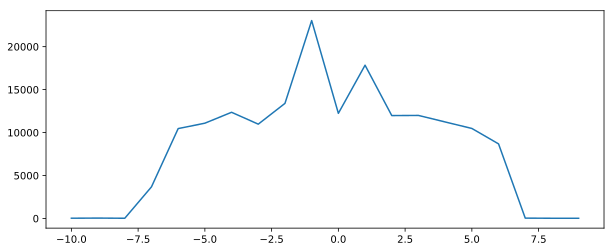

In [51]:
# switch x and y from openmsi orientation
# 19,84 is openmsi centoid
# access it like this here: imStack[19,84]
y_center = 84
x_center = 20
radius = 10
fig = plt.figure(figsize=(10,4))
plt.plot(np.arange(y_center-radius,y_center+radius)-y_center,imStack[y_center-radius:y_center+radius,x_center,0])
plt.show()

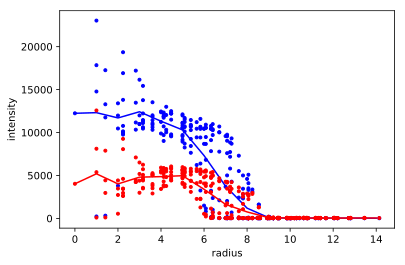

In [54]:
x_mesh,y_mesh = np.meshgrid(np.arange(x_center - radius,x_center + radius),
                            np.arange(y_center - radius, y_center + radius))
coords = [(y,x) for x,y in zip(x_mesh.flatten(),y_mesh.flatten())]

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

radial_distance = []
radial_intensity = []
for c in coords:
    radial_distance.append(cart2pol(c[0]-y_center,c[1]-x_center)[0])
    radial_intensity.append(imStack[c[0],c[1]][0])
plt.plot(radial_distance,radial_intensity,'b.',alpha=0.5)

df = pd.DataFrame()
df['distance'] = radial_distance
df['distance'] = df['distance'].round()
df['intensity_1'] = radial_intensity
g = df.groupby('distance').mean()
plt.plot(g.index,g['intensity_1'],'b-')

radial_distance = []
radial_intensity = []
for c in coords:
    radial_distance.append(cart2pol(c[0]-y_center,c[1]-x_center)[0])
    radial_intensity.append(imStack[c[0],c[1]][1])
plt.plot(radial_distance,radial_intensity,'r.',alpha=0.5)

df = pd.DataFrame()
df['distance'] = radial_distance
df['distance'] = df['distance'].round()
df['intensity_1'] = radial_intensity
g = df.groupby('distance').mean()
plt.plot(g.index,g['intensity_1'],'r-')

plt.xlabel('radius')
plt.ylabel('intensity')
plt.show()